# Run Analysis

This notebook analyze the information generated by the experiment I had for **m4 daily micro dataset** with gap being 5.

In [1]:
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from pprint import pprint

plt.rcParams['figure.figsize'] = (20, 8)
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

Load run information

In [2]:
plt.style.use('ggplot')

In [3]:
experiments = ['10-07-2022--21-25-03', '11-07-2022--09-57-02']
run_infos = []
for exp in experiments:
    with open(f'{exp}/run_info.json', 'r') as file:
        run_infos.append(json.load(file))

pprint(run_infos)

[{'Avg. len of series': 1229.24,
  'config input': {'dataset': {'cumulate used': 0,
                               'file name': 'm4_daily_micro.json',
                               'file path': 'datasets/',
                               'file type': 'json',
                               'max length': 1500,
                               'min length': 1000,
                               'use series': 25},
                   'execution config': {'n of workers': 24},
                   'modelling config': {'forecast horizon': 1,
                                        'gap': 5,
                                        'retrain window': 10,
                                        'score measure': 'SMAPE',
                                        'test size': 0.1,
                                        'validation size': 0.1},
                   'models': ['EN', 'MLP', 'LSVR', 'RF', 'LGBM', 'ETS'],
                   'transformation config': {'interp kind': ['linear'],
                  

Load agents' run information

In [26]:
agent_infos_raw = {}

for i, run in enumerate(run_infos):
    run_id = run['run time'][0]
    models = run['config input']['models']

    for m in models:

        agent_1 = f'{m}_raw'
        agent_2 = f'{m}_tran'

        if i == 0:
            with open(f'{run_id}/{agent_1}.json', 'r') as file:
                agent_infos_raw[agent_1] = json.load(file)
            with open(f'{run_id}/{agent_2}.json', 'r') as file:
                agent_infos_raw[agent_2] = json.load(file)
        else:
            with open(f'{run_id}/{agent_1}.json', 'r') as file:
                agent_infos_raw[agent_1] = {**agent_infos_raw[agent_1], **json.load(file)}
            with open(f'{run_id}/{agent_2}.json', 'r') as file:
                agent_infos_raw[agent_2] = {**agent_infos_raw[agent_2], **json.load(file)}


In [27]:
list(agent_infos_raw.keys())

['EN_raw',
 'EN_tran',
 'MLP_raw',
 'MLP_tran',
 'LSVR_raw',
 'LSVR_tran',
 'RF_raw',
 'RF_tran',
 'LGBM_raw',
 'LGBM_tran',
 'ETS_raw',
 'ETS_tran']

Check if all time series have been played successfully. Exclude those which not all agents have played successfully.

In [28]:
agent_fails = {k: [] for k in run.keys()}
series_excluded = []

for agent, plays in agent_infos_raw.items():
    for series, info in plays.items():
        if info['message'] != None:
            agent_fails[agent].append(series)
            series_excluded.append(series)

if not series_excluded:
    print('All agents have successfully ran on all series.')
else:
    print(series_excluded)
    print(agent_fails)

All agents have successfully ran on all series.


Check if all the agents have played on the same set of time series.

In [29]:
played = [set(plays.keys()) for plays in agent_infos_raw.values()]
played_by_all = played[0].intersection(*played[1:])
print('Series played by all agents: ')
print(played_by_all)

Series played by all agents: 
{'581', '555', '554', '591', '580', '598', '579', '573', '586', '571', '572', '599', '596', '582', '574', '578', '129', '585', '577', '590', '594', '144', '454', '593', '583', '575', '600', '597', '576', '130'}


 Only include the time series played by all agents.

In [30]:
dict_filter = lambda x, y: dict([ (i,x[i]) for i in x if i in set(y) ]) # dict, mask (keys)

agent_infos = {agent: dict_filter(plays, played_by_all) for agent, plays in agent_infos_raw.items()}

In [31]:
n_series_ran = len(agent_infos['RF_raw'])
print(f'Number of series ran: {n_series_ran}')

Number of series ran: 30


## A glance at model prediction

Before digging into the details, take a quick look on how the model is doing on the tests. In this section, I manually took one of the time series that was played by all agents.

In [32]:
# the time series
with open('m4_daily_micro_2.json', 'r') as file:
    ts = json.load(file)

print(ts.keys())

use = '600'

dict_keys(['573', '600'])


In [33]:
# filter out the test set

test_size = run_infos[0]['config input']['modelling config']['test size']
test_set_count = int(len(ts[use]) * test_size)

test_set = ts[use][-(test_set_count):]

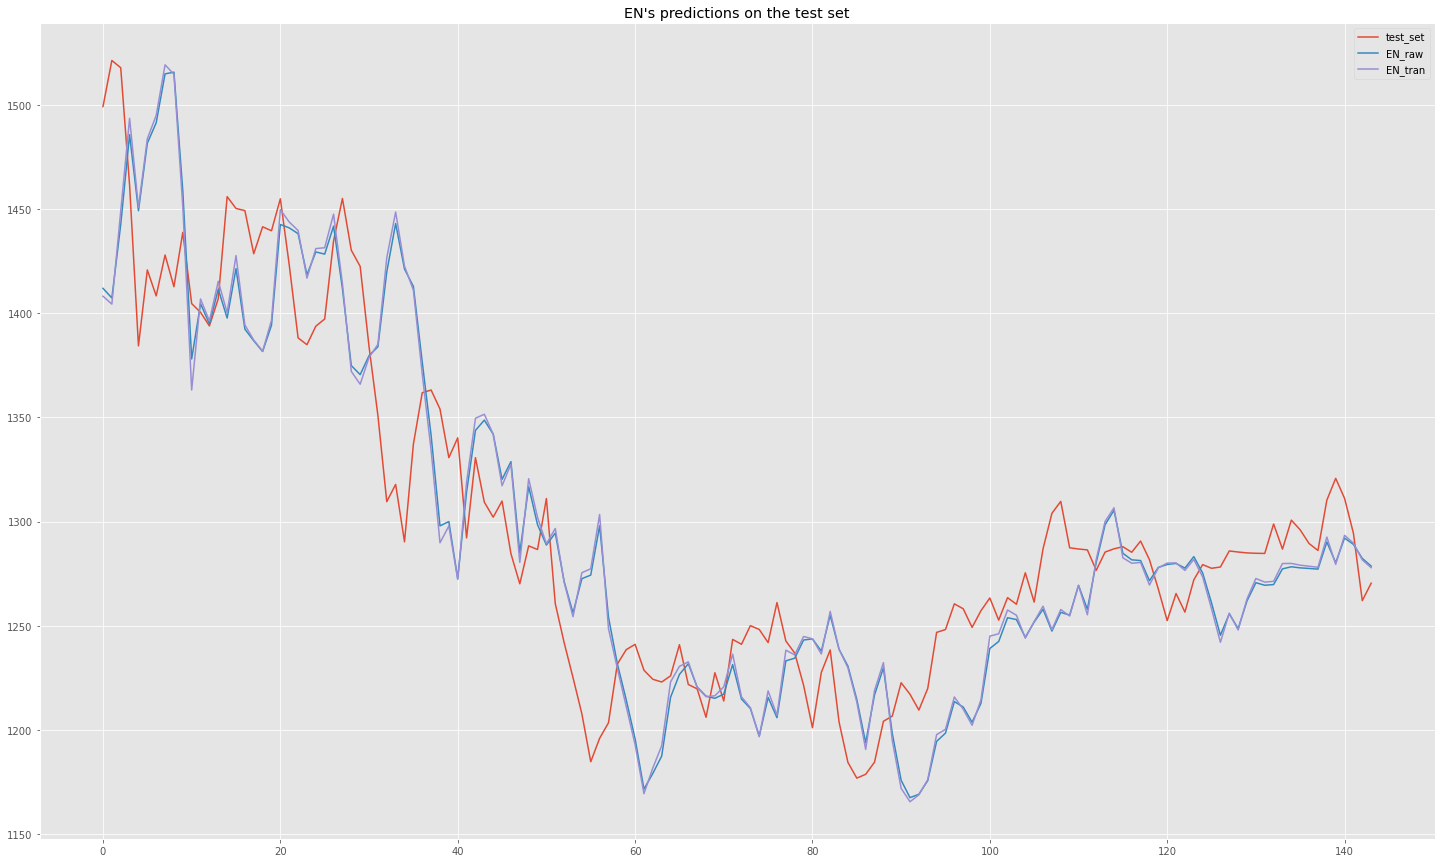

In [34]:
model = 'EN'

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on the test set')
plt.legend()
plt.show()

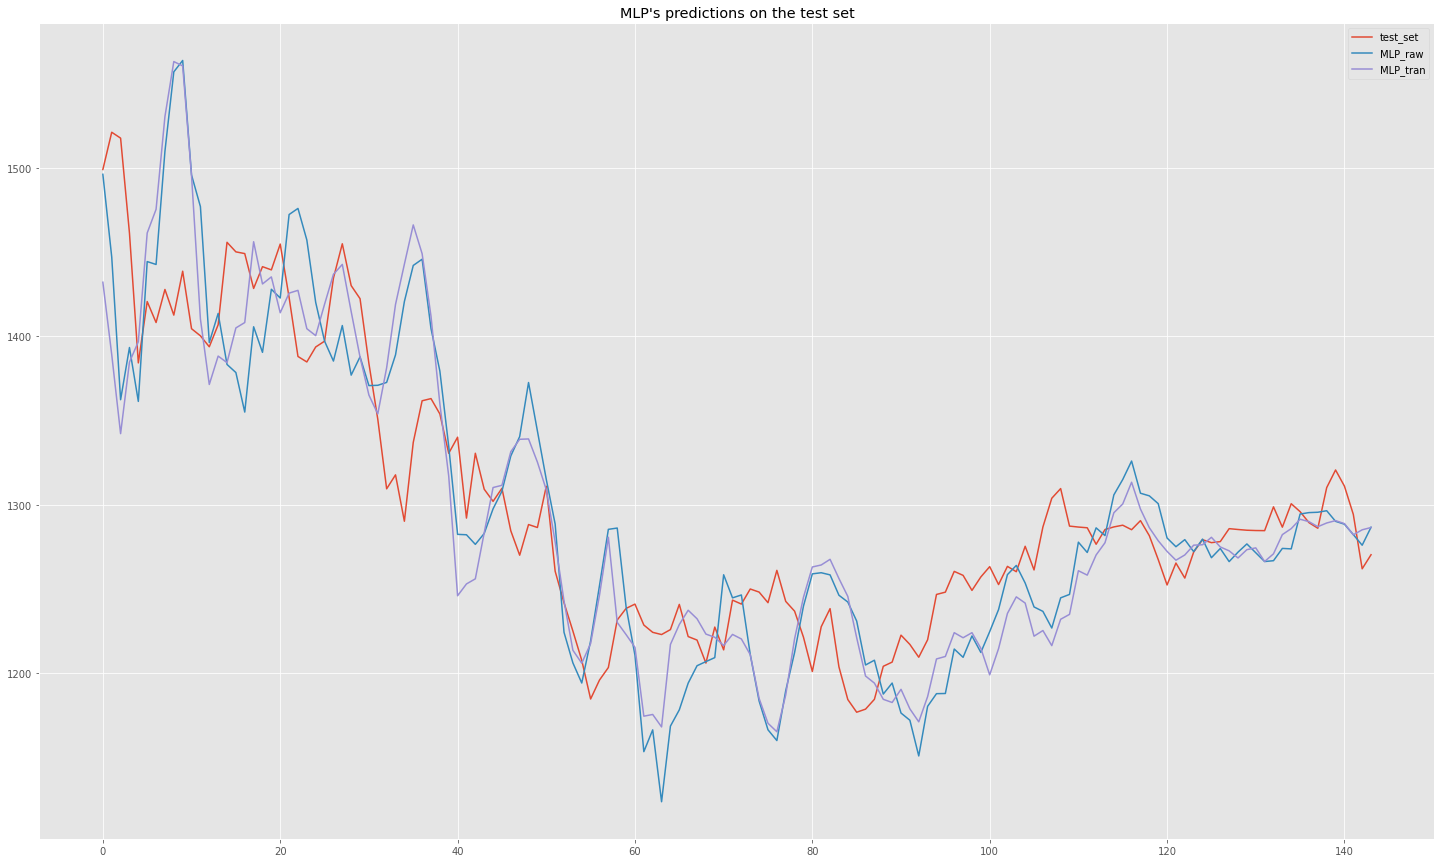

In [35]:
model = 'MLP'

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on the test set')
plt.legend()
plt.show()

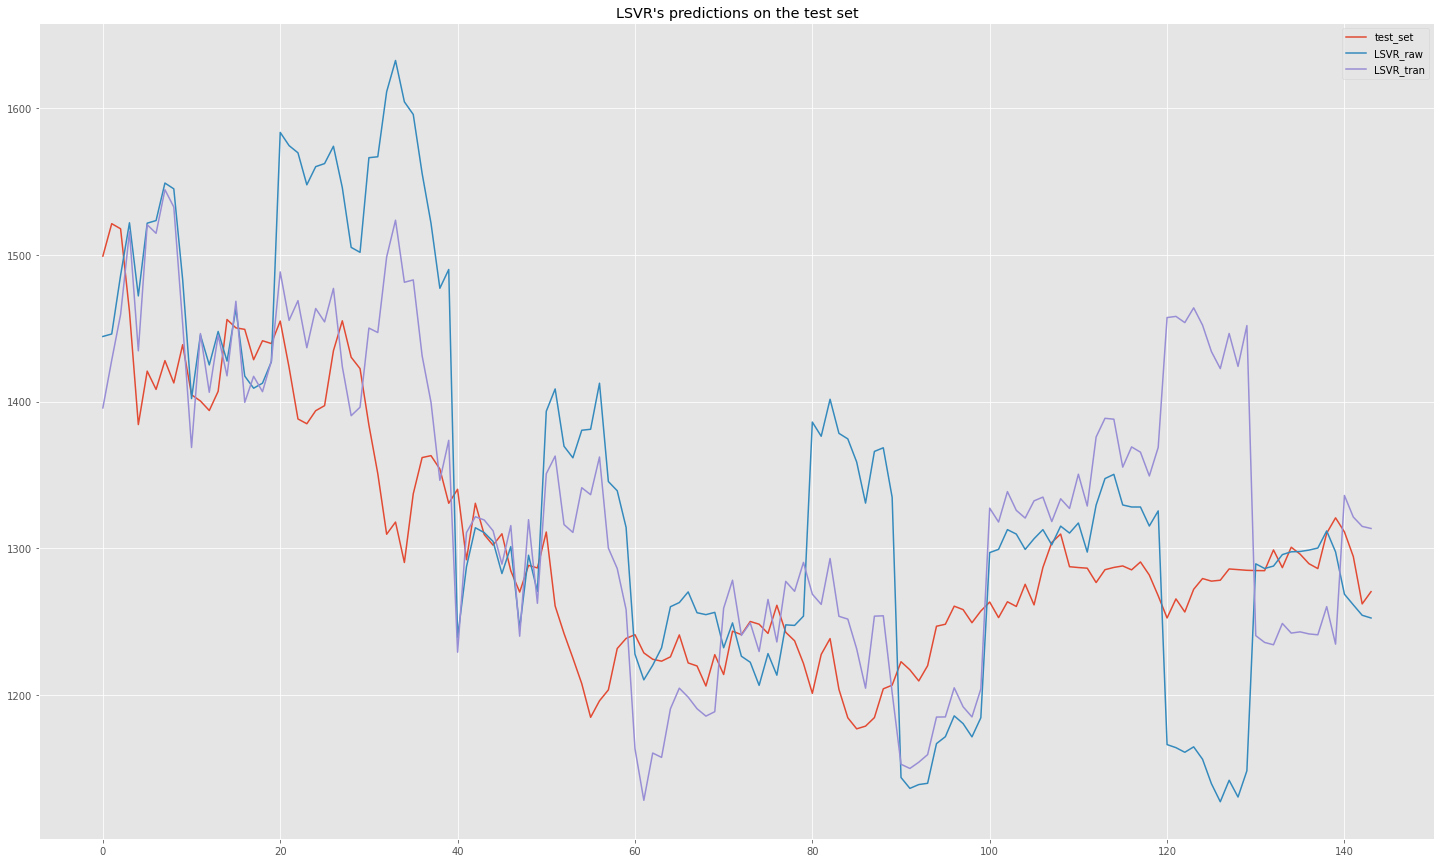

In [36]:
model = 'LSVR'

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on the test set')
plt.legend()
plt.show()

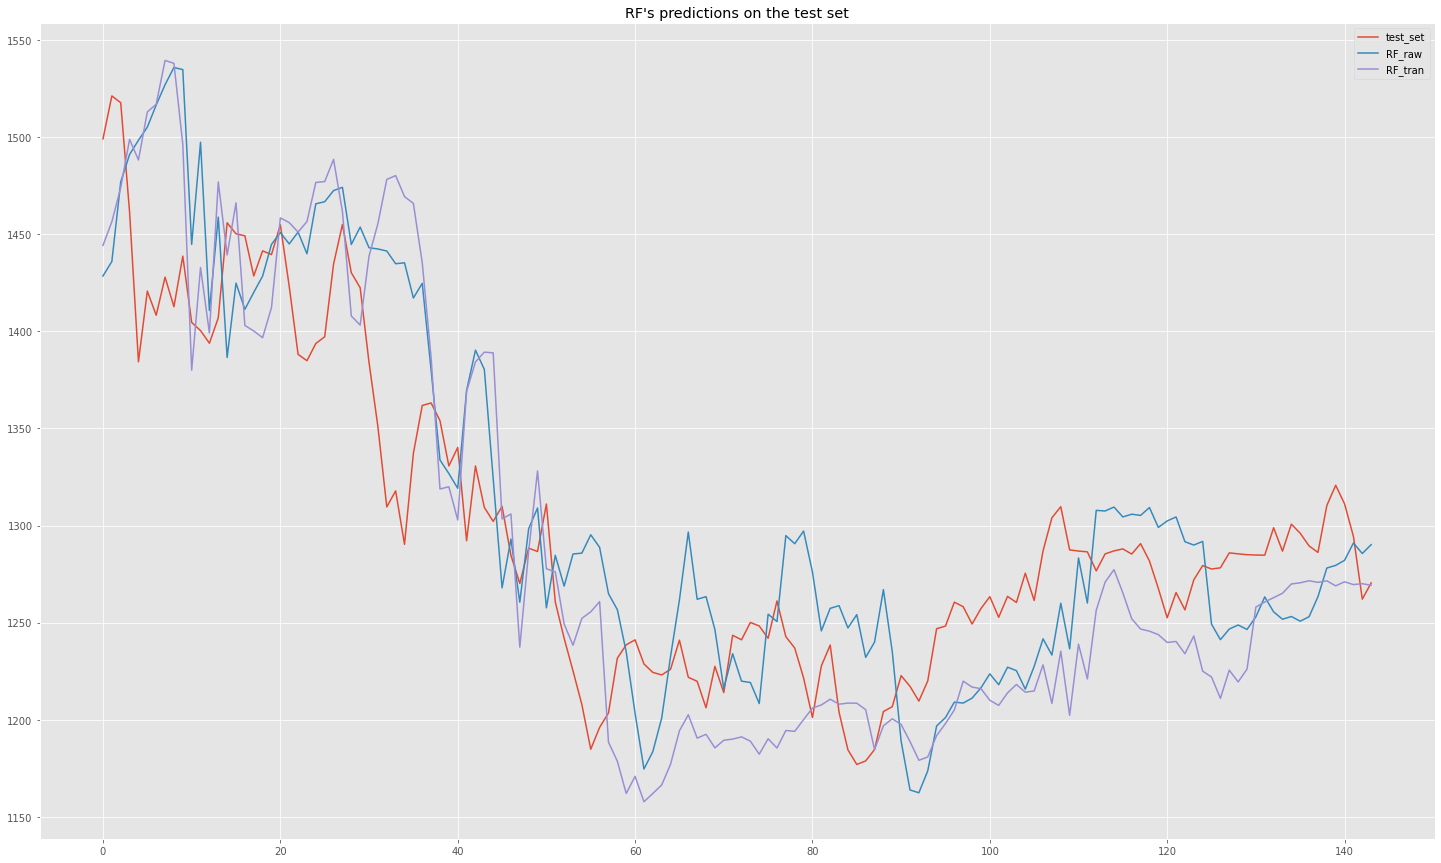

In [37]:
model = 'RF'

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on the test set')
plt.legend()
plt.show()

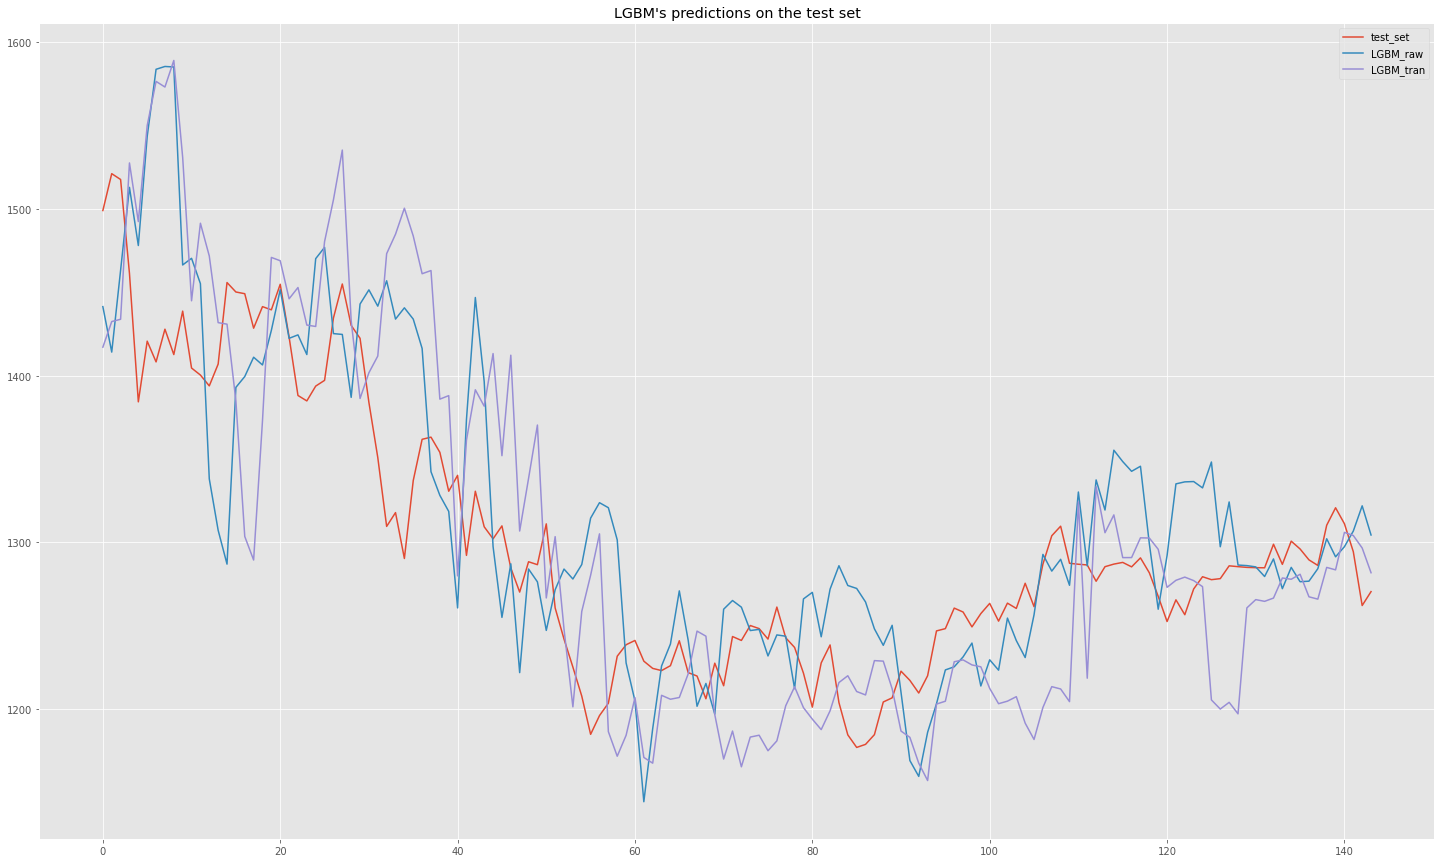

In [38]:
model = 'LGBM'

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on the test set')
plt.legend()
plt.show()

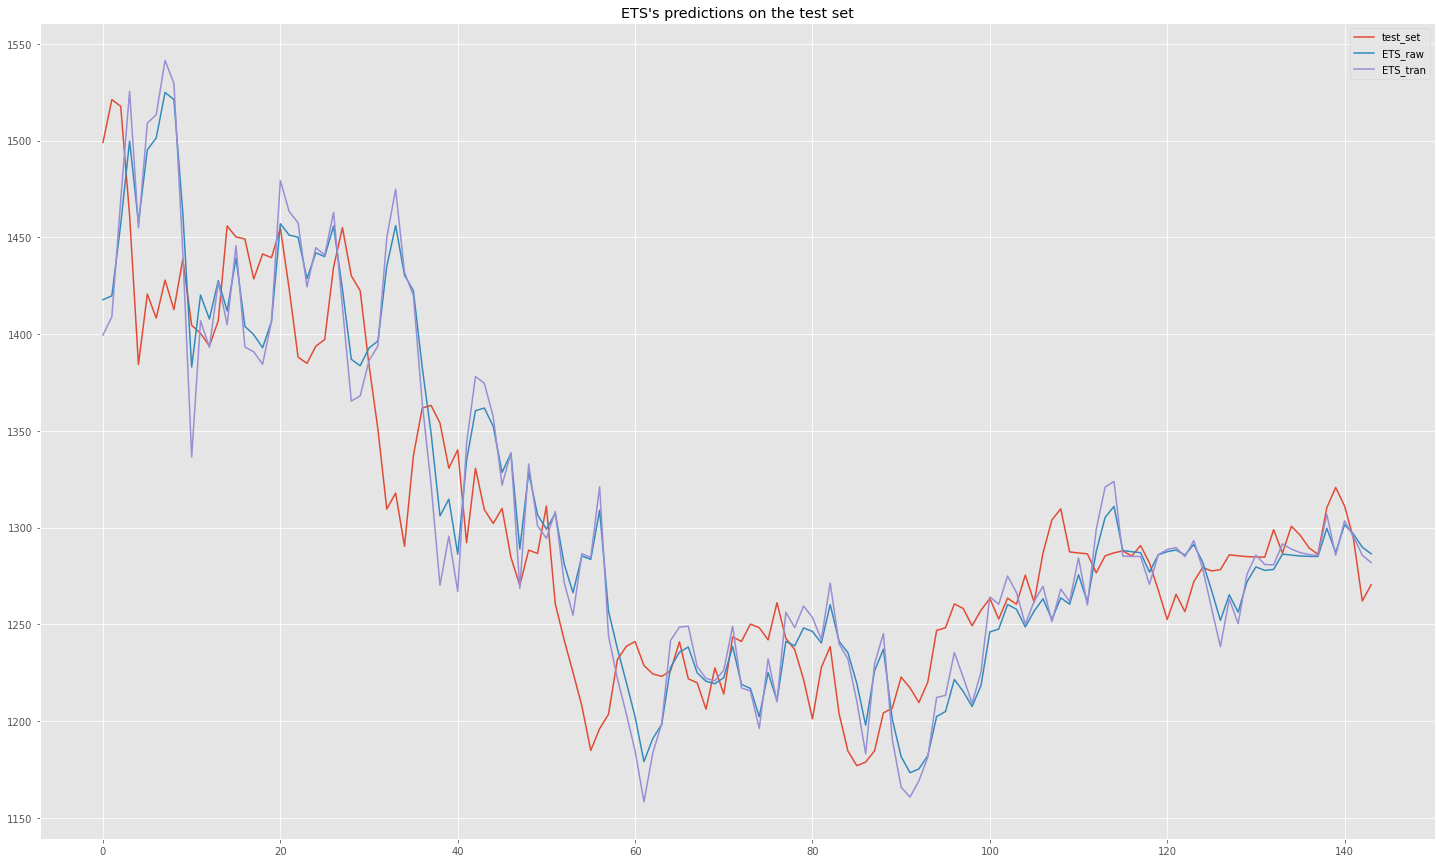

In [39]:
model = 'ETS'

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on the test set')
plt.legend()
plt.show()

In [40]:
use = '573'

In [41]:
# filter out the test set

test_size = run_infos[0]['config input']['modelling config']['test size']
test_set_count = int(len(ts[use]) * test_size)

test_set = ts[use][-(test_set_count):]

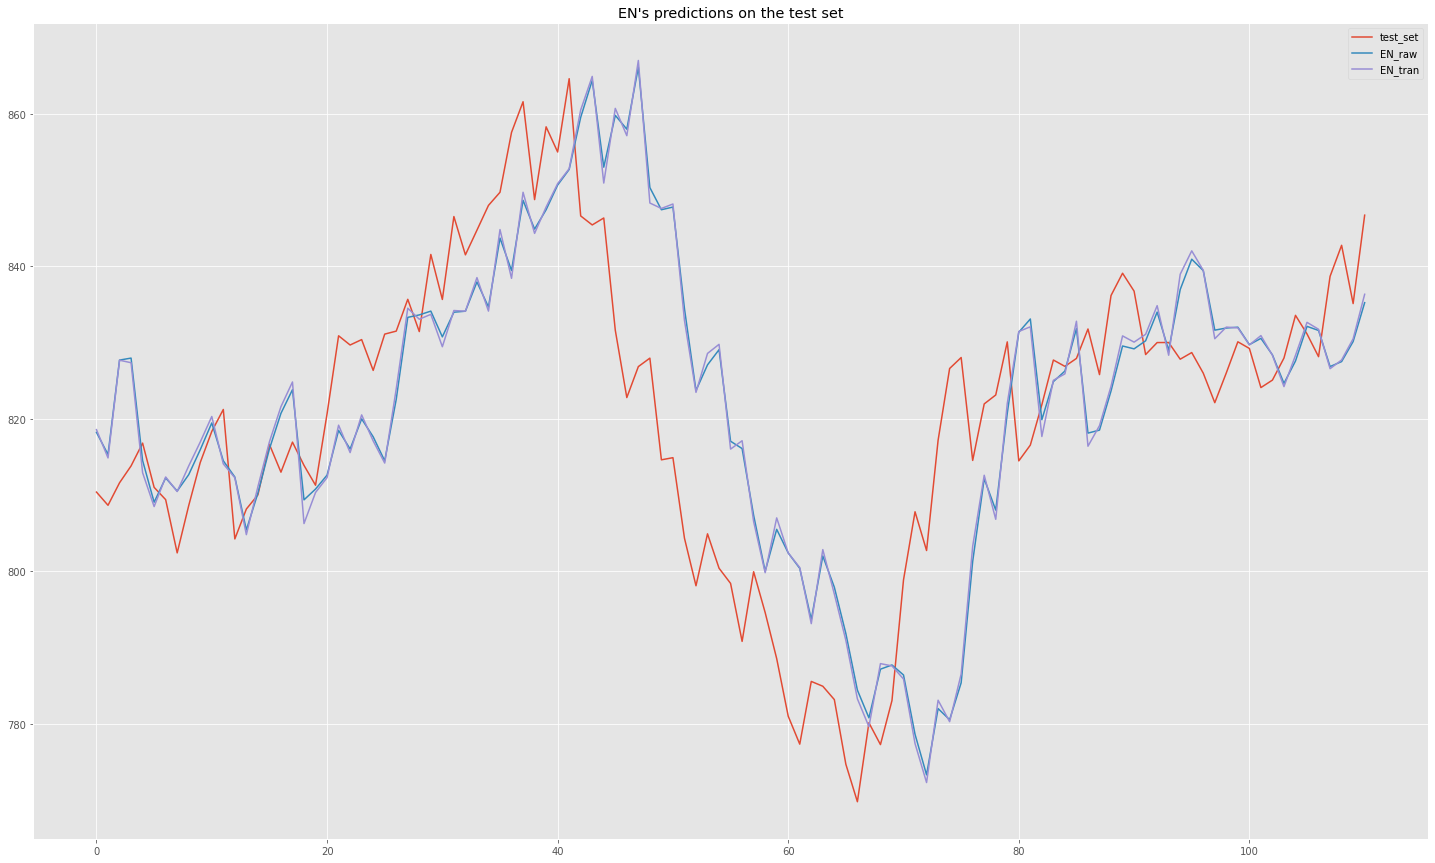

In [42]:
model = 'EN'

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on the test set')
plt.legend()
plt.show()

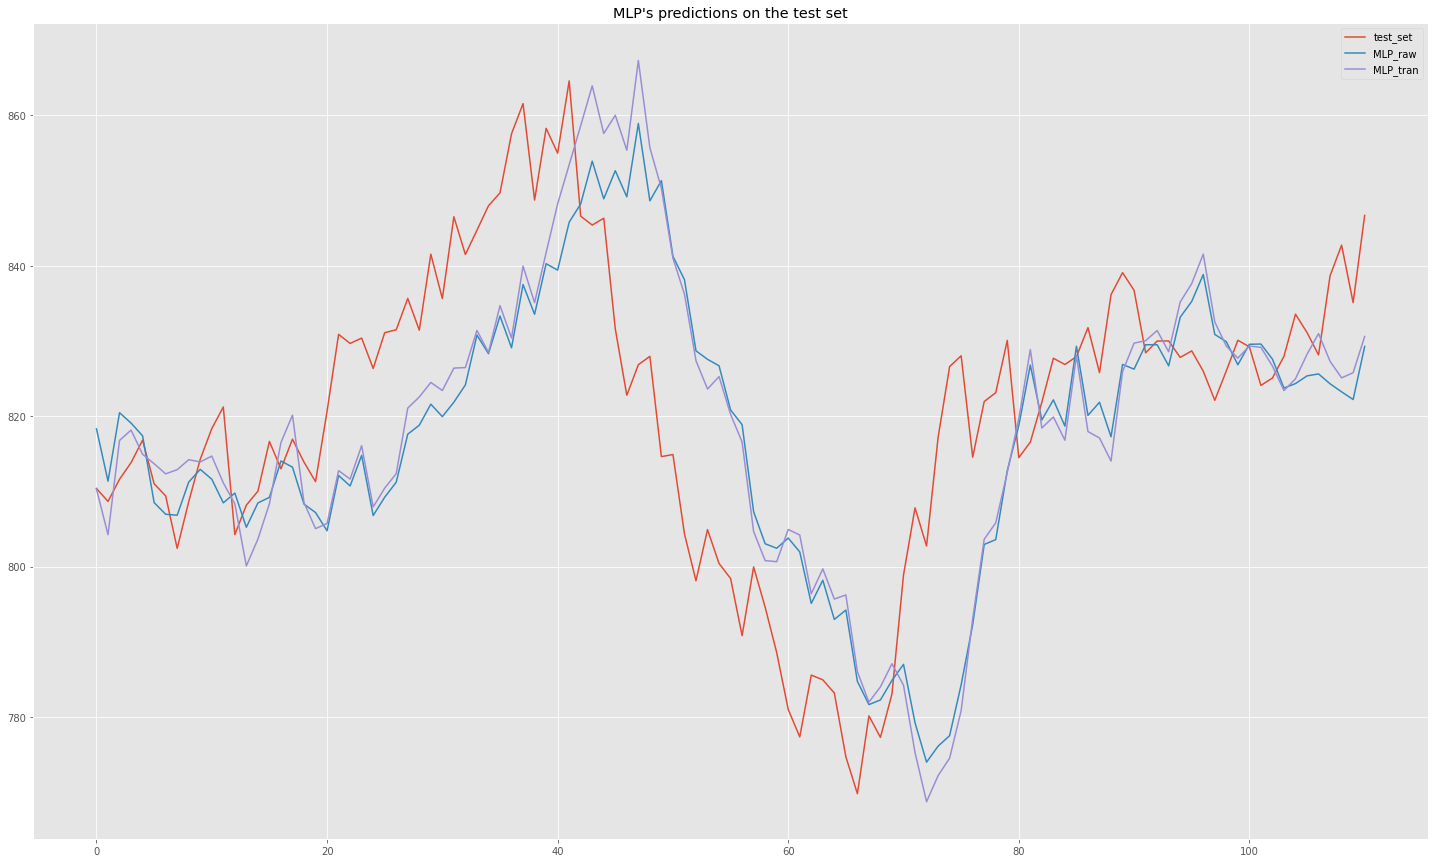

In [43]:
model = 'MLP'

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on the test set')
plt.legend()
plt.show()

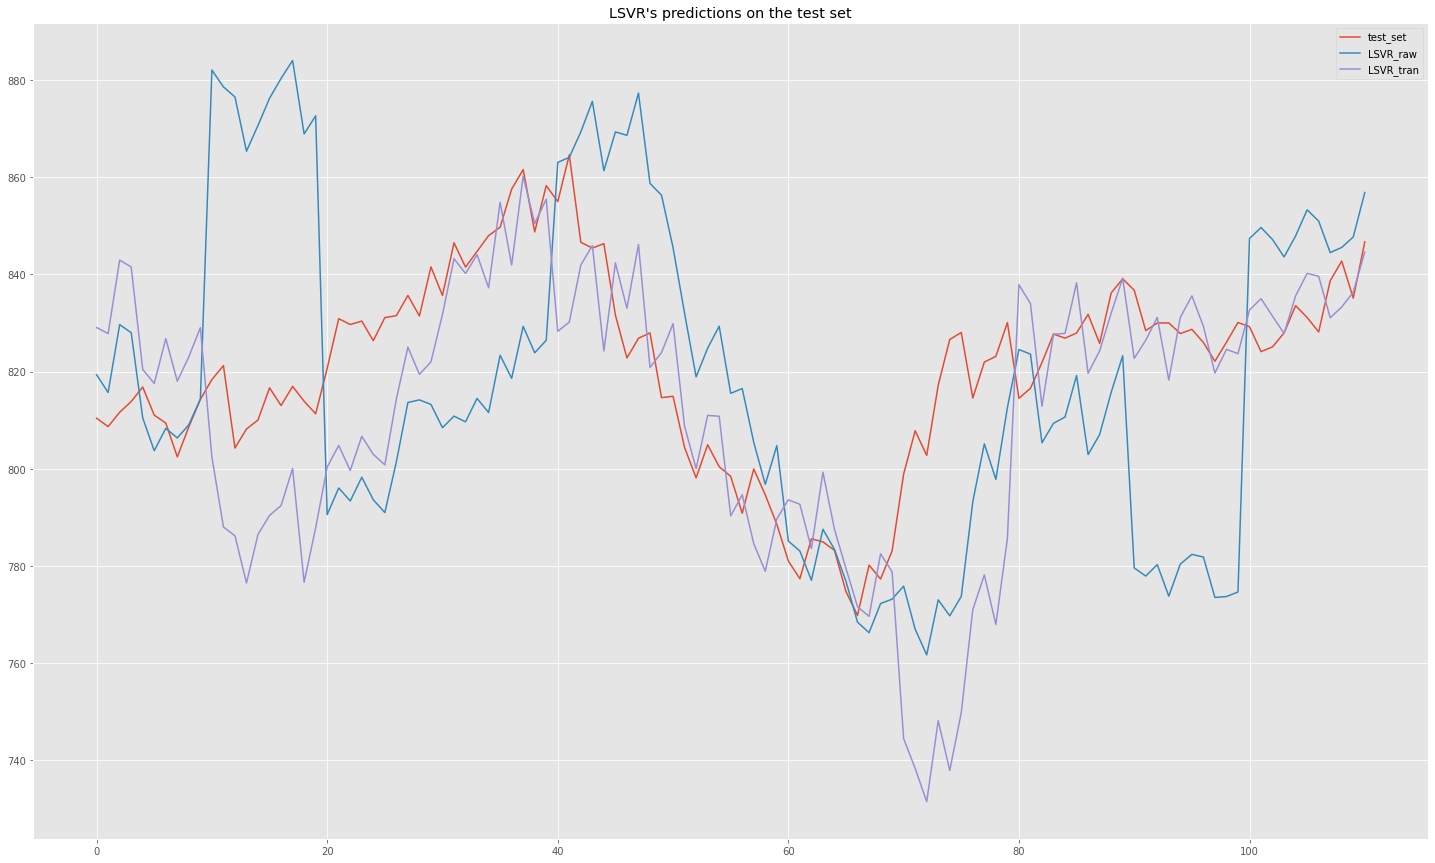

In [44]:
model = 'LSVR'

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on the test set')
plt.legend()
plt.show()

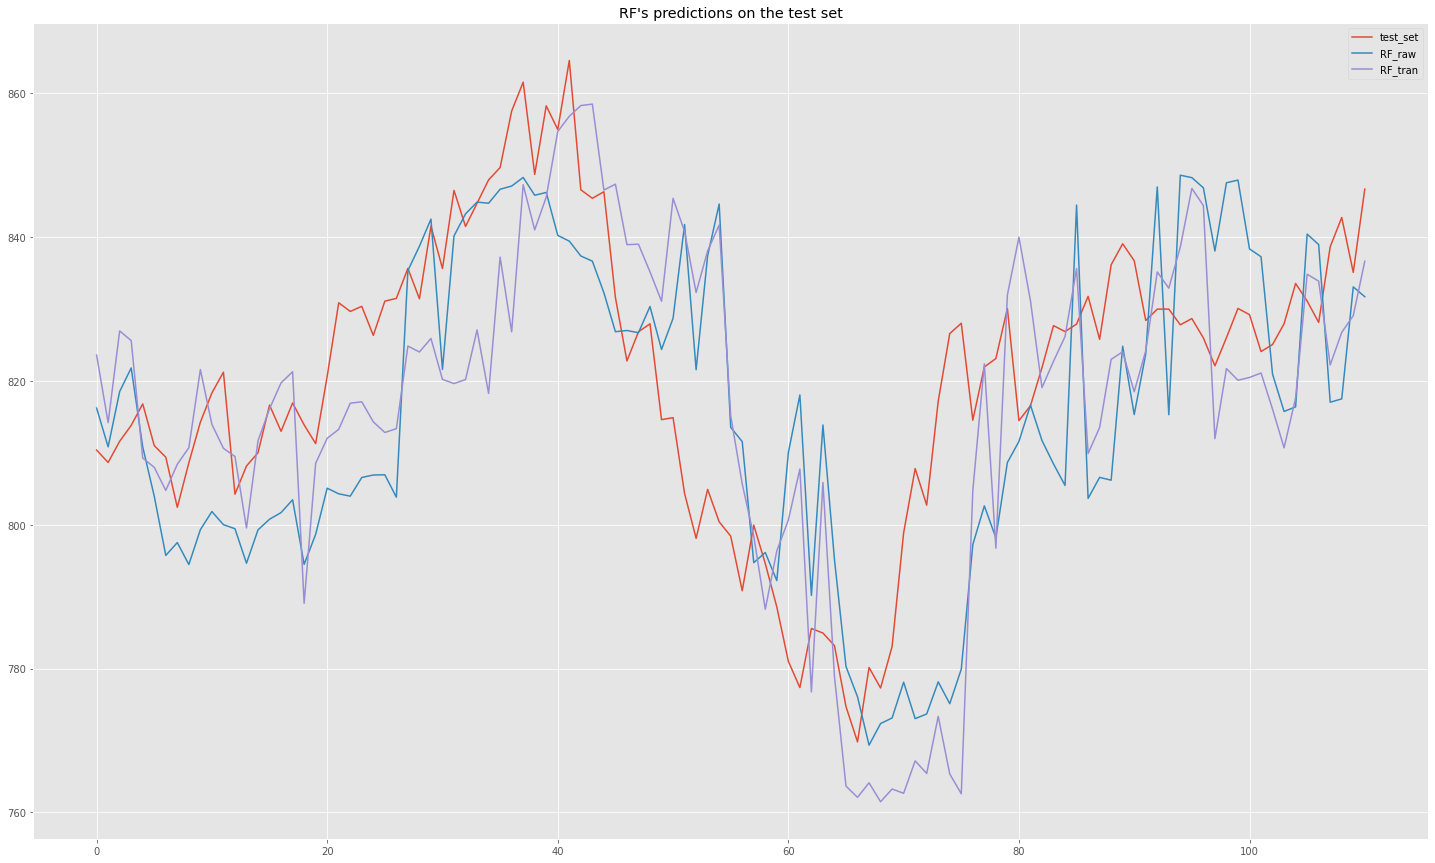

In [45]:
model = 'RF'

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on the test set')
plt.legend()
plt.show()

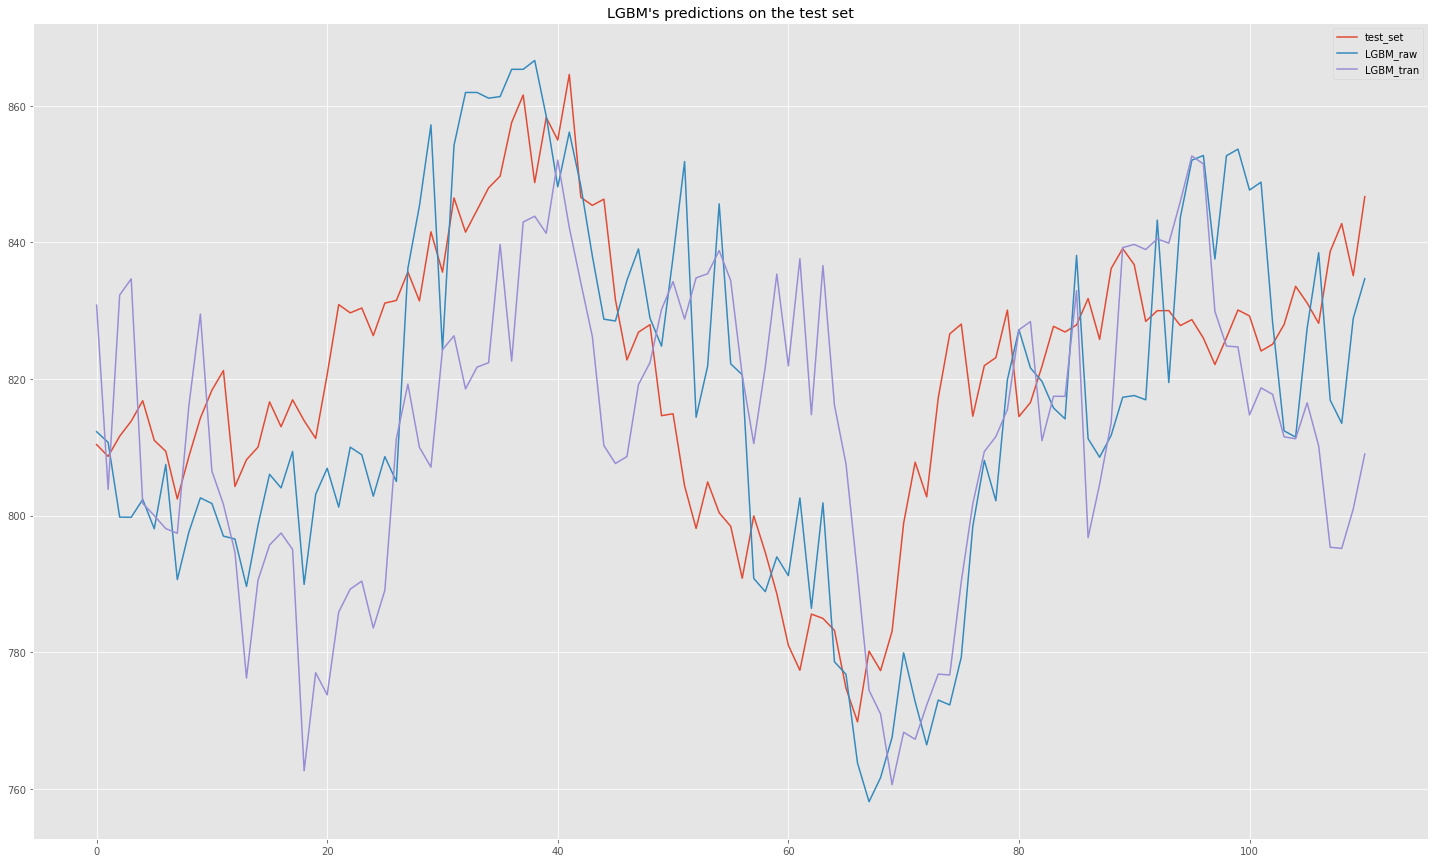

In [46]:
model = 'LGBM'

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on the test set')
plt.legend()
plt.show()

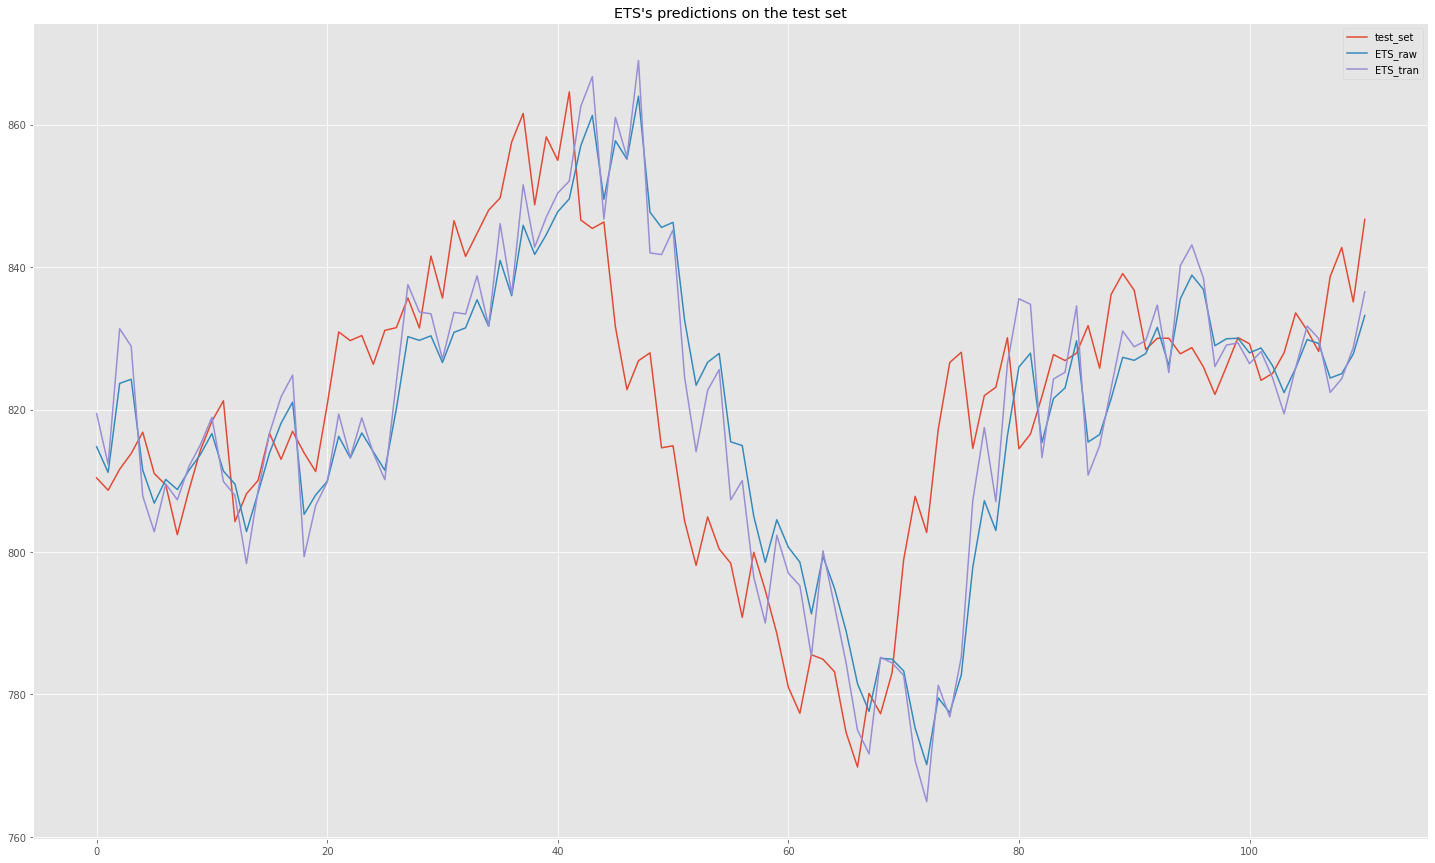

In [47]:
model = 'ETS'

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on the test set')
plt.legend()
plt.show()

## Statistics of overall performance

In this section, we calculate some statistics that concludes the general performance of each agent over the time series played.

In addition to SMAPE, we compute the ranking of each agent per time series. So each agent will have a ranking for a time series, ranging from 1 to the number of agent involved. I store this ranking info to the `agent_infos` dictionary, as how SMAPE is stored for each agent per time series.

In [48]:
for agent, plays in agent_infos.items():
    for series, play_info in plays.items():
        score = play_info['test SMAPE']
        lower = [1 for a in agent_infos.keys() if agent_infos[a][series]['test SMAPE']-score < 0]
        play_info['ranking'] = sum(lower) + 1

In [49]:
numbers = {
    agent: {
        'SMAPEs': [],
        'rankings': []
    } for agent in agent_infos
}

stats = {
    agent: {
        'mean SMAPE': None,
        'std. SMAPE': None,
        'mean ranking': None,
        'std. ranking': None
    } for agent in agent_infos
}

for agent, plays in agent_infos.items():
    for series, play_info in plays.items():
        numbers[agent]['SMAPEs'].append(play_info['test SMAPE'])
        numbers[agent]['rankings'].append(play_info['ranking'])
    
    stats[agent]['mean SMAPE'] = np.mean(numbers[agent]['SMAPEs'])
    stats[agent]['std. SMAPE'] = np.std(numbers[agent]['SMAPEs'])
    stats[agent]['mean ranking'] = np.mean(numbers[agent]['rankings'])
    stats[agent]['std. ranking'] = np.std(numbers[agent]['rankings'])

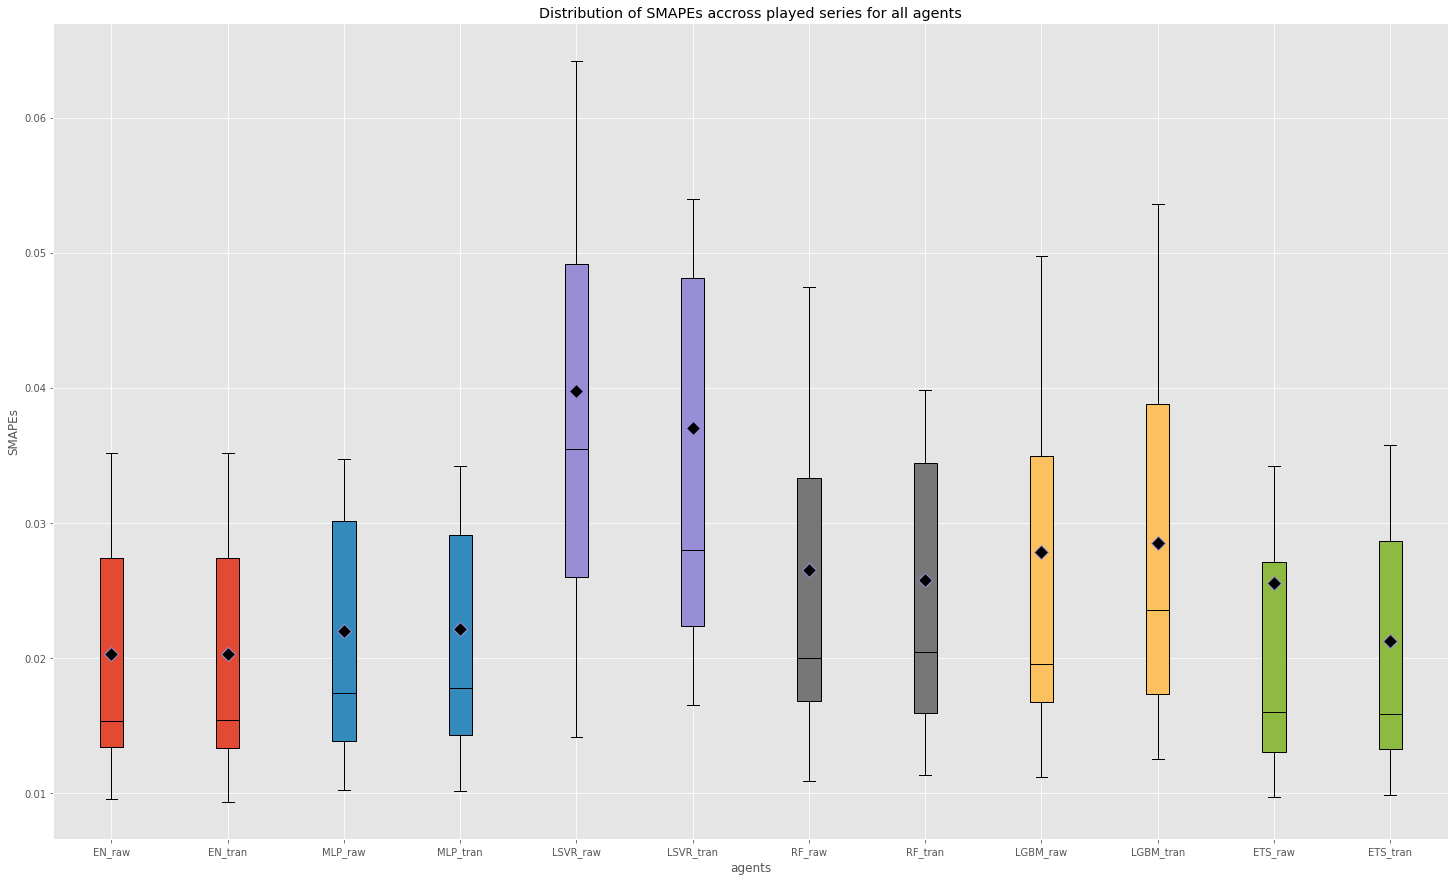

In [50]:
plt.figure(figsize= (25, 15))
n_agents = len(list(numbers.keys()))
colors = [f'C{i}' for i in range(n_agents//2)]
meanprop = dict(marker='D', markerfacecolor='black', markersize=10)

box = plt.boxplot(
    [agent['SMAPEs'] for agent in numbers.values()],
    showbox=True,
    showfliers=False,
    labels=list(numbers.keys()),
    widths=0.2,
    showmeans=True,
    meanprops=meanprop,
    patch_artist=True)

for i, patch in enumerate(box['boxes']):
    c = i // (n_agents//(n_agents//2))
    patch.set_facecolor(colors[c])
    box['medians'][i].set_color('k')

plt.title(f'Distribution of SMAPEs accross played series for all agents')
plt.xlabel('agents')
plt.ylabel('SMAPEs')
plt.show()

In [51]:
numbers = {
    agent: {
        'SMAPEs': [],
        'rankings': []
    } for agent in agent_infos
}

stats = {
    agent: {
        'mean SMAPE': None,
        'std. SMAPE': None,
        'mean ranking': None,
        'std. ranking': None
    } for agent in agent_infos
}

for agent, plays in agent_infos.items():
    for series, play_info in plays.items():
        numbers[agent]['SMAPEs'].append(play_info['test SMAPE'])
        numbers[agent]['rankings'].append(play_info['ranking'])
    
    stats[agent]['mean SMAPE'] = np.mean(numbers[agent]['SMAPEs'])
    stats[agent]['std. SMAPE'] = np.std(numbers[agent]['SMAPEs'])
    stats[agent]['mean ranking'] = np.mean(numbers[agent]['rankings'])
    stats[agent]['std. ranking'] = np.std(numbers[agent]['rankings'])

## Ranking of the agents

In this section, we compute the alpha-confidence interval of the rankings for the agents.

In [52]:
series_ran = agent_infos['MLP_raw'].keys()
n_series_ran = len(series_ran)

alpha = 0.1
Q = len(list(agent_infos.keys()))
P = n_series_ran
dist = np.random.standard_normal(size=Q)
r_lower, r_upper = np.min(dist), np.max(dist)
qrange = list(np.arange(r_lower, r_upper, step=(r_upper-r_lower)/100))
q_alpha_Q = qrange[-int(alpha*100)]

def conf_limit(Q, P, mean_R, q_alpha_Q):
    stat = 0.5 * q_alpha_Q * np.sqrt(Q*(Q+1)/(12 * P))
    return round(mean_R-stat, 6), round(mean_R+stat, 6)

for agent in agent_infos.keys():
    stats[agent][f'{100-int(alpha*100)}% ranking confi. limits'] = conf_limit(Q, P, stats[agent]['mean ranking'], q_alpha_Q)

leaderboard = pd.DataFrame(stats)
leaderboard

,EN_raw,EN_tran,MLP_raw,MLP_tran,LSVR_raw,LSVR_tran,RF_raw,RF_tran,LGBM_raw,LGBM_tran,ETS_raw,ETS_tran
mean SMAPE,0.020305,0.020309,0.022009,0.022176,0.039745,0.037013,0.026503,0.025762,0.027837,0.028545,0.025521,0.021224
std. SMAPE,0.010667,0.010693,0.011063,0.011399,0.024463,0.024529,0.013582,0.013126,0.015526,0.015774,0.02559,0.01167
mean ranking,2.666667,2.833333,5.2,5.633333,11.2,11.0,7.9,7.733333,8.233333,8.733333,2.766667,4.1
std. ranking,1.468181,1.416176,1.989975,2.136716,1.045626,1.290994,1.776701,1.730767,1.745152,1.913693,2.824693,1.619671
90% ranking confi. limits,"(2.188418, 3.144916)","(2.355084, 3.311582)","(4.721751, 5.678249)","(5.155084, 6.111582)","(10.721751, 11.678249)","(10.521751, 11.478249)","(7.421751, 8.378249)","(7.255084, 8.211582)","(7.755084, 8.711582)","(8.255084, 9.211582)","(2.288418, 3.244916)","(3.621751, 4.578249)"


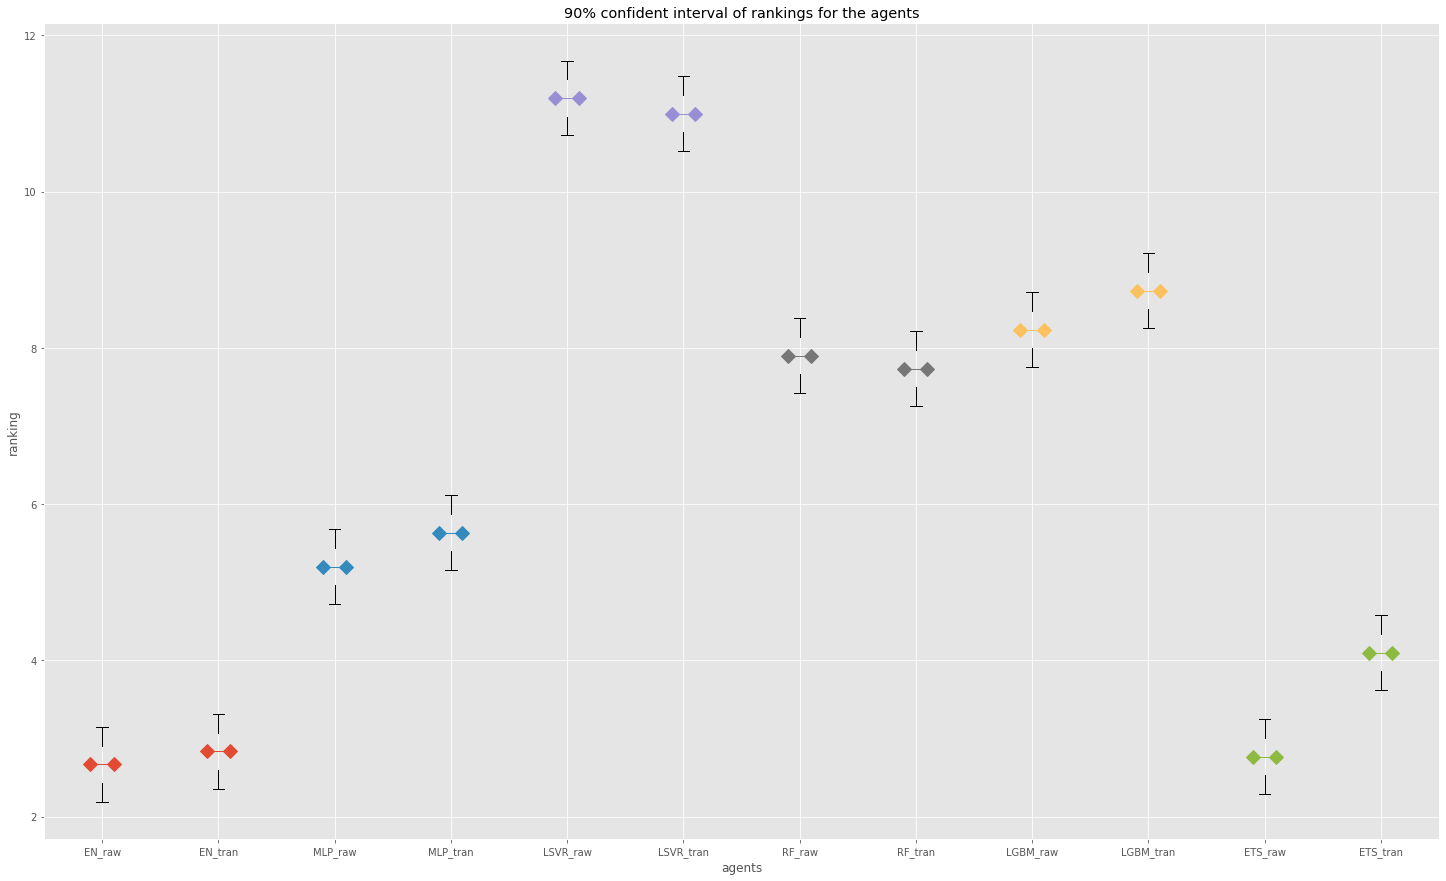

In [53]:
n_agents = len(list(numbers.keys()))
colors = [f'C{i}' for i in range(n_agents//2)]
medianprop = dict(marker='D', markersize=10)
plt.figure(figsize= (25, 15))
box = plt.boxplot(
    [
        [
            agent[f'{100-int(alpha*100)}% ranking confi. limits'][0],
            agent['mean ranking'],
            agent[f'{100-int(alpha*100)}% ranking confi. limits'][1]
        ] for agent in stats.values()
    ],
    showbox=False,
    labels=list(numbers.keys()),
    widths=0.2,
    medianprops=medianprop,
    patch_artist=True)

for i, patch in enumerate(box['medians']):
    c = i // (n_agents//(n_agents//2))
    patch.set_color(colors[c])

plt.title(f'{100-int(alpha*100)}% confident interval of rankings for the agents')
plt.xlabel('agents')
plt.ylabel('ranking')
plt.show()

## Fraction best

In this section, we compute another performance measure, called the fraction-best measure. Building on our basis performance measure SMAPE, we compute how much of a fraction out of all played time series that a model beats all other models. This measure lets us know the potential of an agent being exceptionally good conditional on the given datasets.

The results are shown in the last row of the table.

In [54]:
for agent, play_info in stats.items():
    play_info['frac best'] = np.sum([1 for r in numbers[agent]['rankings'] if r == 1])/n_series_ran

leaderboard = pd.DataFrame(stats)
leaderboard

,EN_raw,EN_tran,MLP_raw,MLP_tran,LSVR_raw,LSVR_tran,RF_raw,RF_tran,LGBM_raw,LGBM_tran,ETS_raw,ETS_tran
mean SMAPE,0.020305,0.020309,0.022009,0.022176,0.039745,0.037013,0.026503,0.025762,0.027837,0.028545,0.025521,0.021224
std. SMAPE,0.010667,0.010693,0.011063,0.011399,0.024463,0.024529,0.013582,0.013126,0.015526,0.015774,0.02559,0.01167
mean ranking,2.666667,2.833333,5.2,5.633333,11.2,11.0,7.9,7.733333,8.233333,8.733333,2.766667,4.1
std. ranking,1.468181,1.416176,1.989975,2.136716,1.045626,1.290994,1.776701,1.730767,1.745152,1.913693,2.824693,1.619671
90% ranking confi. limits,"(2.188418, 3.144916)","(2.355084, 3.311582)","(4.721751, 5.678249)","(5.155084, 6.111582)","(10.721751, 11.678249)","(10.521751, 11.478249)","(7.421751, 8.378249)","(7.255084, 8.211582)","(7.755084, 8.711582)","(8.255084, 9.211582)","(2.288418, 3.244916)","(3.621751, 4.578249)"
frac best,0.233333,0.1,0.0,0.066667,0.0,0.0,0.0,0.033333,0.0,0.0,0.533333,0.033333


# Feature importance analysis

In this section, we investigate the parameters estimated by the machine learning models to gain more insights on how the models learn the problems. In particular, we go through

- feature importance reported by the tree-based models (RF, LGBM)
- coefficients estimated by the linear regression model (EN)

## Tree-based models

In this section, we investigate the feature importance reported by the tree-based methods.

In [55]:
# find out the maximum number of lags possible
max_n_lag = 21
states = False
if states:
    n_states = 8
else:
    n_states = 0

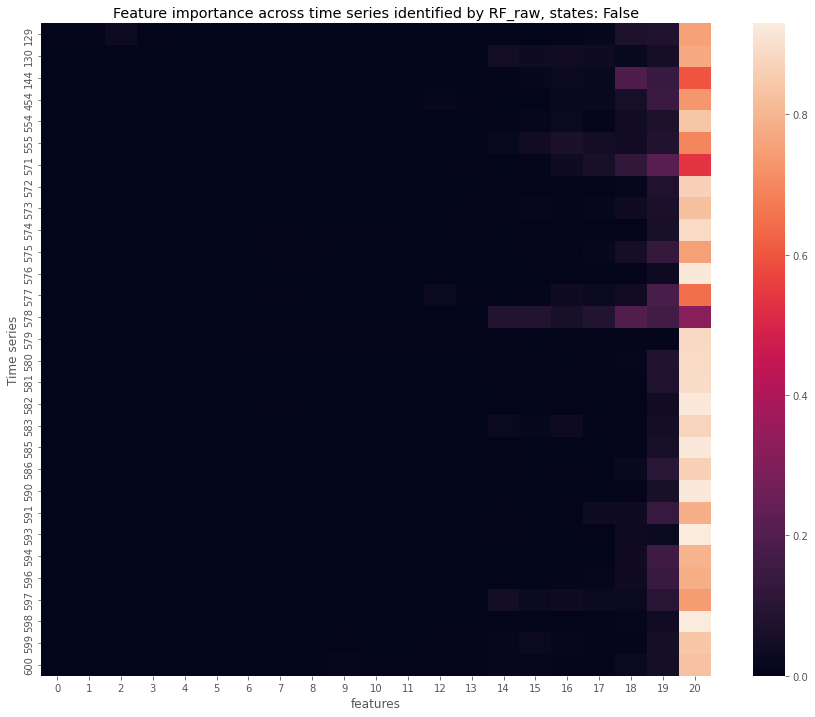

In [56]:
import matplotlib.pylab as pltlab
import seaborn as sns

model = 'RF_raw'

heatmap_grid = []

for play in agent_infos[model].values():
    fi = play['feature importances'][-1]
    if len(fi) == max_n_lag + n_states:
        heatmap_grid.append(fi)
    else:
        n_gap = max_n_lag + n_states - len(fi)
        heatmap_grid.append([0 for _ in range(n_gap)] + fi)

data = np.array(heatmap_grid)

plt.figure(figsize=(15, 12))
sns.heatmap(data, yticklabels=agent_infos[model].keys())
plt.xlabel('features')
plt.ylabel('Time series')
plt.title(f'Feature importance across time series identified by {model}, states: {states}')
plt.show()

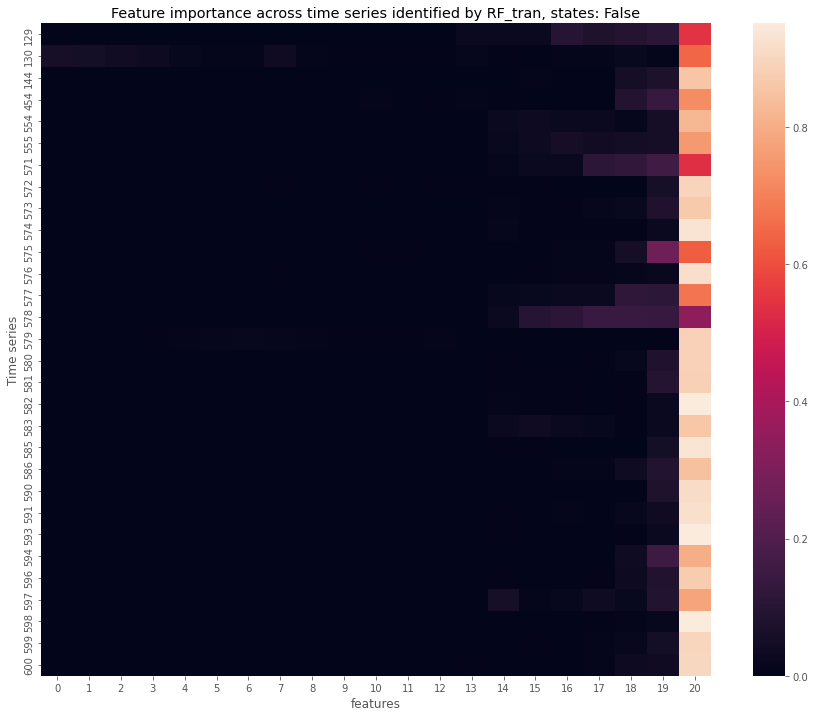

In [21]:
model = 'RF_tran'

heatmap_grid = []

for play in agent_infos[model].values():
    fi = play['feature importances'][-1]
    if len(fi) == max_n_lag + n_states:
        heatmap_grid.append(fi)
    else:
        n_gap = max_n_lag + n_states - len(fi)
        heatmap_grid.append([0 for _ in range(n_gap)] + fi)

data = np.array(heatmap_grid)

plt.figure(figsize=(15, 12))
sns.heatmap(data, yticklabels=agent_infos[model].keys())
plt.xlabel('features')
plt.ylabel('Time series')
plt.title(f'Feature importance across time series identified by {model}, states: {states}')
plt.show()

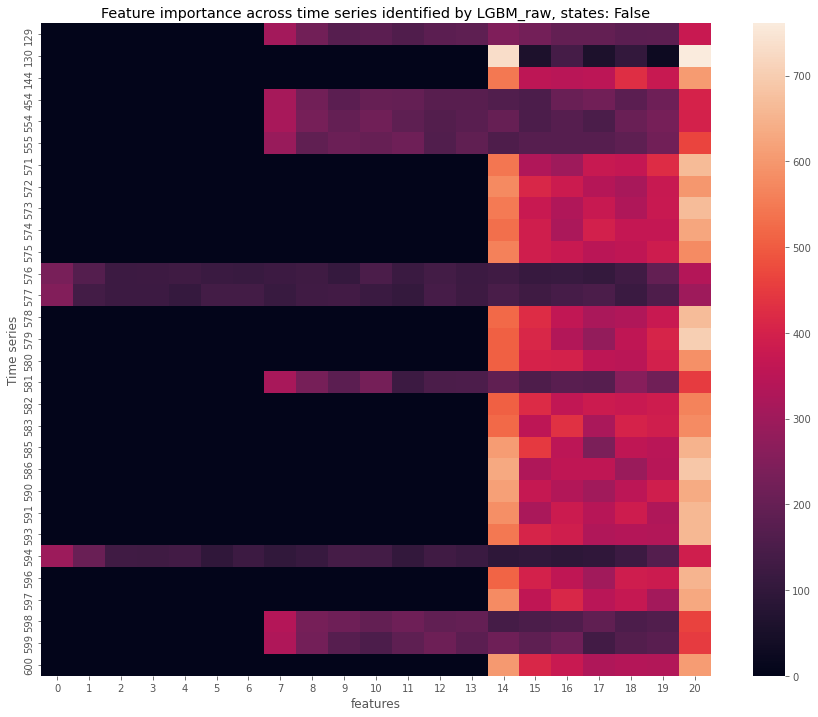

In [22]:
model = 'LGBM_raw'

heatmap_grid = []

for play in agent_infos[model].values():
    fi = play['feature importances'][-1]
    if len(fi) == max_n_lag + n_states:
        heatmap_grid.append(fi)
    else:
        n_gap = max_n_lag + n_states - len(fi)
        heatmap_grid.append([0 for _ in range(n_gap)] + fi)

data = np.array(heatmap_grid)

plt.figure(figsize=(15, 12))
sns.heatmap(data, yticklabels=agent_infos[model].keys())
plt.xlabel('features')
plt.ylabel('Time series')
plt.title(f'Feature importance across time series identified by {model}, states: {states}')
plt.show()

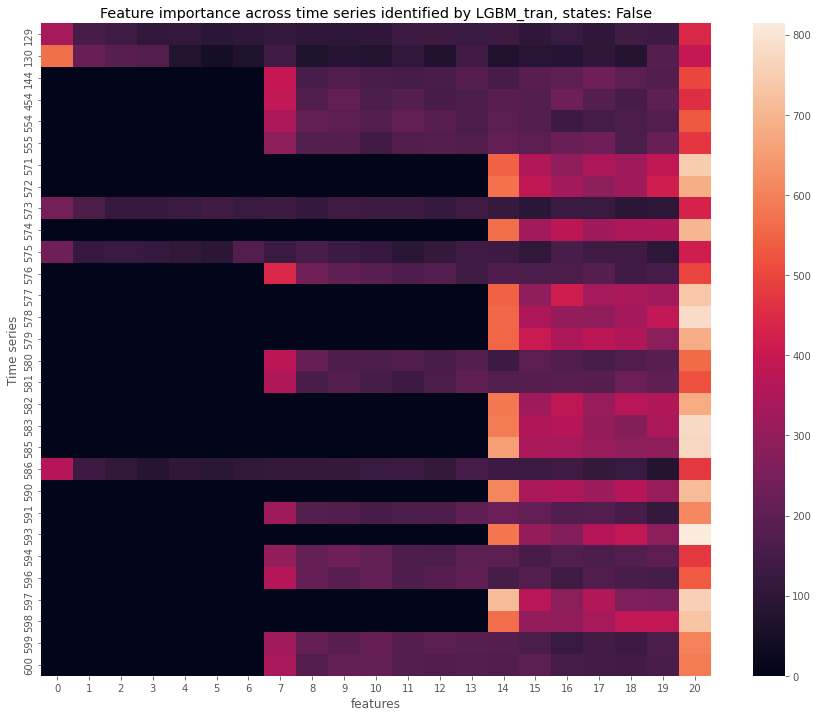

In [23]:
model = 'LGBM_tran'

heatmap_grid = []

for play in agent_infos[model].values():
    fi = play['feature importances'][-1]
    if len(fi) == max_n_lag + n_states:
        heatmap_grid.append(fi)
    else:
        n_gap = max_n_lag + n_states - len(fi)
        heatmap_grid.append([0 for _ in range(n_gap)] + fi)

data = np.array(heatmap_grid)

plt.figure(figsize=(15, 12))
sns.heatmap(data, yticklabels=agent_infos[model].keys())
plt.xlabel('features')
plt.ylabel('Time series')
plt.title(f'Feature importance across time series identified by {model}, states: {states}')
plt.show()

# Linear regression model

In this section, we investigate the coefficients estimated by the linear regression model, in this case, EN. Note that since we fitted the linear model with intercept, we have an additional feature to the number of lags.

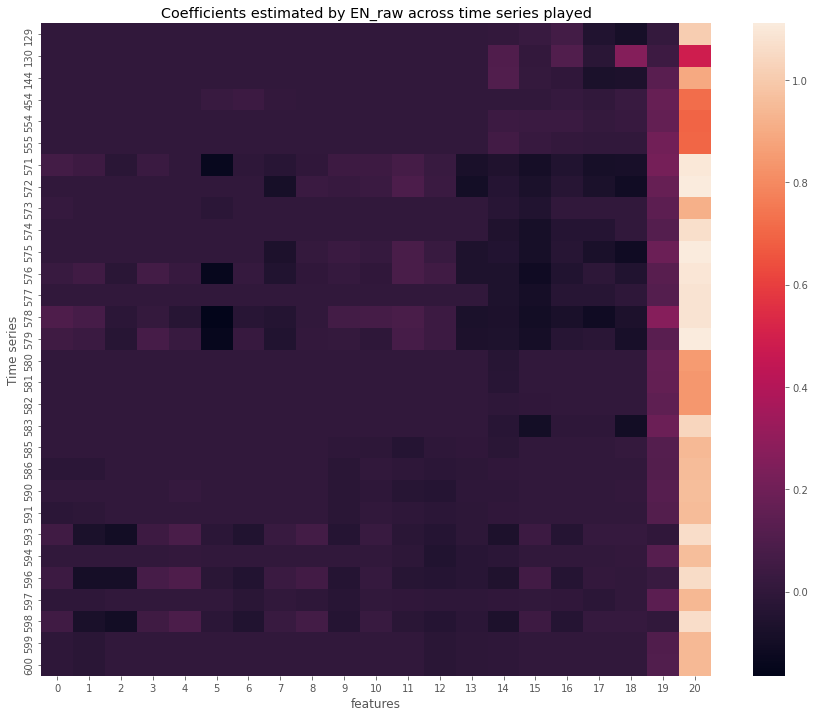

In [24]:
model = 'EN_raw'

# @NOTE: do not turn this to true, scale incomparable!!!
include_intercept = False

n_intercept = 1

heatmap_grid = []

for play in agent_infos[model].values():
    if include_intercept:
        coeffs = play['coeffs'][-1]
        n_intercept_c = n_intercept
    else:
        coeffs = play['coeffs'][-1][n_intercept:]
        n_intercept_c = 0
    if len(coeffs) == max_n_lag + n_intercept_c + n_states:
        heatmap_grid.append(coeffs)
    else:
        n_gap = max_n_lag + n_states + n_intercept_c - len(coeffs)
        heatmap_grid.append([0 for _ in range(n_gap)] + coeffs)

data = np.array(heatmap_grid)

plt.figure(figsize=(15, 12))
sns.heatmap(data, yticklabels=agent_infos[model].keys())
plt.xlabel('features')
plt.ylabel('Time series')
plt.title(f'Coefficients estimated by {model} across time series played')
plt.show()

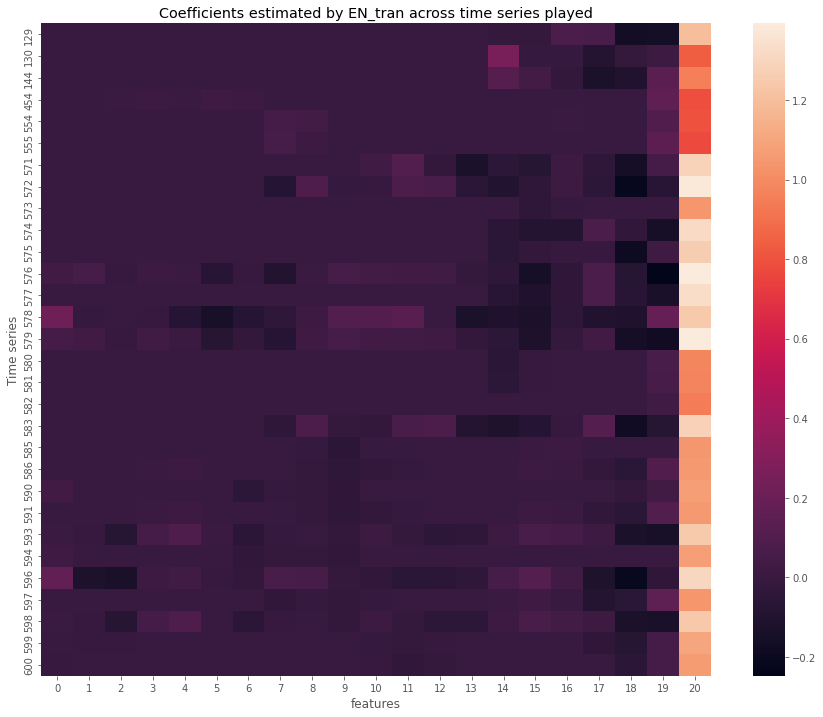

In [25]:
model = 'EN_tran'

# @NOTE: do not turn this to true, scale incomparable!!!
include_intercept = False

n_intercept = 1

heatmap_grid = []

for play in agent_infos[model].values():
    if include_intercept:
        coeffs = play['coeffs'][-1]
        n_intercept_c = n_intercept
    else:
        coeffs = play['coeffs'][-1][n_intercept:]
        n_intercept_c = 0
    if len(coeffs) == max_n_lag + n_intercept_c + n_states:
        heatmap_grid.append(coeffs)
    else:
        n_gap = max_n_lag + n_states + n_intercept_c - len(coeffs)
        heatmap_grid.append([0 for _ in range(n_gap)] + coeffs)

data = np.array(heatmap_grid)

plt.figure(figsize=(15, 12))
sns.heatmap(data, yticklabels=agent_infos[model].keys())
plt.xlabel('features')
plt.ylabel('Time series')
plt.title(f'Coefficients estimated by {model} across time series played')
plt.show()